#Data preprocessing: WHO data on suicide rates and mental health resources

This notebook is for data preprocessing. The datasets are from the WHO and the World Bank. 

All datasets used are as such:


*  Mental health governance
*  Mental health human resources
*  Mental health service availability: Beds
*  Mental health service availability: Facility
*  Suicide rate estimates, age-standardized
*  Suicide rate estimates, crude, 10-year age groups.

They can be found at https://apps.who.int/gho/data/node.main.MENTALHEALTH?lang=en.

The structure of this notebook is as such:

1. Import libraries and datasets
2. Preliminary column cleaning & encoding data

> 2.1 The human resources data

> 2.2 The mental health governance data

> 2.3 The bed data

> 2.4 The facility data

> 2.5 The suicide rate by age data

> 2.6 The suicide rate by year data

3. Merge all datasets into one BIG dataframe
4. External data: Add income classicification
5. Create four dataframes based on income group; handle NA
6. Visualization

#1. Import libraries and datasets

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from google.colab import drive 
import seaborn as sns
import matplotlib.pyplot as plt
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# LOAD DATASETS
hr_data = pd.read_csv('gdrive/My Drive/Hackathon for Mental Health/data/human_resources.csv')
gov_data = pd.read_csv('gdrive/My Drive/Hackathon for Mental Health/data/governance.csv')
beds_data = pd.read_csv('gdrive/My Drive/Hackathon for Mental Health/data/beds.csv')
fac_data = pd.read_csv('gdrive/My Drive/Hackathon for Mental Health/data/facilities.csv')
sr_tenyear_data = pd.read_csv('gdrive/My Drive/Hackathon for Mental Health/data/suicide_tenyear.csv')
sr_age_stand_data = pd.read_csv('gdrive/My Drive/Hackathon for Mental Health/data/suicide_age_stand.csv')

#2. Preliminary column cleaning & encoding data
Go through each dataset to see its shape and information. Drop the columns that have too many missing rows. Encode binary data.


##2.1 The human resources data

In [ ]:
hr_data.info() # preserve all columns of hr_data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Country                                                                  154 non-null    object 
 1   Year                                                                     154 non-null    int64  
 2   Psychiatrists working in mental health sector (per 100 000 population)   146 non-null    float64
 3   Nurses working in mental health sector (per 100 000 population)          127 non-null    float64
 4   Social workers working in mental health sector (per 100 000 population)  100 non-null    float64
 5   Psychologists working in mental health sector (per 100 000 population)   120 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 7.3+ KB


In [ ]:
hr_data['Year'].unique()

# all data of this dataset are acquired after 2013
# we will just remember this
# i am deleting the year column 

array([2016, 2015, 2017, 2013, 2014])

In [ ]:
hr_data = hr_data.drop('Year', axis=1)
hr_data.head()

,Country,Psychiatrists working in mental health sector (per 100 000 population),Nurses working in mental health sector (per 100 000 population),Social workers working in mental health sector (per 100 000 population),Psychologists working in mental health sector (per 100 000 population)
0,Afghanistan,0.231,0.098,NaN,0.296
1,Albania,1.471,6.876,1.060,1.231
2,Angola,0.057,0.660,0.022,0.179
3,Antigua and Barbuda,1.001,7.005,4.003,NaN
4,Argentina,21.705,NaN,NaN,222.572


##2.2 The mental health governance data

In [ ]:
gov_data.info()

# drop the government expenditures, year the law was enacted, and publication 
# year of the policy columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 7 columns):
 #   Column                                                                                                             Non-Null Count  Dtype  
---  ------                                                                                                             --------------  -----  
 0   Country                                                                                                            345 non-null    object 
 1   Year                                                                                                               345 non-null    int64  
 2   Government expenditures on mental hospitals as a percentage of total government expenditures on mental health (%)  78 non-null     float64
 3   Stand-alone law for mental health                                                                                  340 non-null    object 
 4   Year the law was enacted (l

In [ ]:
gov_data = gov_data.drop(columns=['Government expenditures on mental hospitals as a percentage \
of total government expenditures on mental health (%)', 'Year the law was enacted \
(latest revision)', 'Publication year of the policy or plan (latest revision)'], axis=1)

# again, all data of this dataset are acquired after 2013
# we will just remember this
# i am deleting the year column 
gov_data = gov_data.drop('Year', axis=1)

# for countries that have more than one rows, preserve only the row with the latest year
# somehow df.drop_duplicates doesn't work completely so i'm just gonna use my code
existing_countries = [] 
for i in gov_data.index:
  if gov_data.at[i, 'Country'] not in existing_countries:
    existing_countries.append(gov_data.at[i, 'Country'])
  else:
    gov_data = gov_data.drop([i])

# encode yes and no into 1 and 0
gov_data['Stand-alone law for mental health'] = gov_data['Stand-alone law for mental health'].replace(['Yes', 'yes', 'Yes '],1)
gov_data['Stand-alone law for mental health'] = gov_data['Stand-alone law for mental health'].replace(['No', 'No '],0)
gov_data['Stand-alone policy or plan for mental health'] = gov_data['Stand-alone policy or plan for mental health'].replace('Yes',1)
gov_data['Stand-alone policy or plan for mental health'] = gov_data['Stand-alone policy or plan for mental health'].replace('No',0)

In [ ]:
gov_data.head()

,Country,Stand-alone law for mental health,Stand-alone policy or plan for mental health
0,Afghanistan,1,1
2,Albania,1,1
4,Algeria,1,0
6,Angola,0,0
7,Antigua and Barbuda,1,1


##2.3 The bed data

In [ ]:
beds_data.info() # don't drop any columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 3 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Country                                                               161 non-null    object 
 1   Beds for mental health in general hospitals (per 100 000 population)  98 non-null     float64
 2   Beds in mental hospitals (per 100 000 population)                     89 non-null     float64
dtypes: float64(2), object(1)
memory usage: 3.9+ KB


In [ ]:
beds_data.head()

,Country,Beds for mental health in general hospitals (per 100 000 population),Beds in mental hospitals (per 100 000 population)
0,Afghanistan,2016.000,2016.000
1,Albania,0.296,0.296
2,Algeria,4.276,16.762
3,Angola,1.507,10.456
4,Antigua and Barbuda,0.187,0.585


##2.4 The facility data

In [ ]:
fac_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 7 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Country                                                            163 non-null    object 
 1   Year                                                               163 non-null    int64  
 2   Mental hospitals (per 100 000 population)                          131 non-null    float64
 3   Mental health units in general hospitals (per 100 000 population)  138 non-null    float64
 4   Mental health outpatient facilities (per 100 000 population)       139 non-null    float64
 5   Mental health day treatment facilities (per 100 000 population)    74 non-null     float64
 6   Community residential facilities (per 100 000 population)          65 non-null     float64
dtypes: float64(5), int64(1), ob

In [ ]:
# remove columns on mental health day treatment and community residential facilities
fac_data = fac_data.drop(columns=['Mental health day treatment facilities (per 100 000 \
population)', 'Community residential facilities (per 100 000 population)'], axis=1)

# yet again, all data of this dataset are acquired after 2013
# we will just remember this
# i am deleting the year column
fac_data = fac_data.drop('Year', axis=1)

In [ ]:
fac_data.head()

,Country,Mental hospitals (per 100 000 population),Mental health units in general hospitals (per 100 000 population),Mental health outpatient facilities (per 100 000 population)
0,Afghanistan,0.003,0.012,0.006
1,Albania,0.068,0.068,0.410
2,Algeria,0.048,0.068,0.048
3,Angola,0.011,NaN,NaN
4,Antigua and Barbuda,1.001,NaN,NaN


##2.5 The suicide rate by age data

In [ ]:
sr_tenyear_data.info() # peserve all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             549 non-null    object 
 1   Sex                 549 non-null    object 
 2   85+ years of age    549 non-null    float64
 3   75-84 years         549 non-null    float64
 4   65-74 years         549 non-null    float64
 5   55-64 years         549 non-null    float64
 6   45-54 years         549 non-null    float64
 7   35-44 years of age  549 non-null    float64
 8   25-34 years of age  549 non-null    float64
 9   15-24 years of age  549 non-null    float64
dtypes: float64(8), object(2)
memory usage: 43.0+ KB


In [ ]:
# create a new dataframe where each country has only one row 
# the columns of this new df will be [gender]+[age range]
# Bsr stands for both sexes' suicide rate
# Msr stands for male suicide rate
# Fsr stands for female suicide rate

sr_by_age_data = pd.DataFrame(columns=['Country', 'Bsr 85+', 'Bsr 75-84', 
                                       'Bsr 65-74', 'Bsr 55-64', 'Bsr 45-54', 
                                       'Bsr 35-44', 'Bsr 25-34', 'Bsr 15-24', 
                                       'Msr 85+', 'Msr 75-84', 'Msr 65-74', 'Msr 55-64', 
                                       'Msr 45-54', 'Msr 35-44', 'Msr 25-34', 
                                       'Msr 15-24', 'Fsr 85+', 'Fsr 75-84', 'Fsr 65-74', 
                                       'Fsr 55-64', 'Fsr 45-54', 'Fsr 35-44', 'Fsr 25-34', 
                                       'Fsr 15-24',])

j = 0
for i in range(0, 549, 3):
  country_name = [sr_tenyear_data.at[i, 'Country']]
  both_sexes_sr = sr_tenyear_data.iloc[i, 2:].values
  male_sr = sr_tenyear_data.iloc[i+1, 2:].values
  female_sr = sr_tenyear_data.iloc[i+2, 2:].values
  row_data = np.concatenate([country_name, both_sexes_sr, male_sr, female_sr])
  
  sr_by_age_data.loc[j] = row_data
  j+=1

In [ ]:
sr_by_age_data.head()
# the sr_by_age_data is now clean. I will be using this one instead of sr_tenyear_data

,Country,Bsr 85+,Bsr 75-84,Bsr 65-74,Bsr 55-64,Bsr 45-54,Bsr 35-44,Bsr 25-34,Bsr 15-24,Msr 85+,...,Msr 25-34,Msr 15-24,Fsr 85+,Fsr 75-84,Fsr 65-74,Fsr 55-64,Fsr 45-54,Fsr 35-44,Fsr 25-34,Fsr 15-24
0,Afghanistan,24.5,8.5,10.7,9.8,9.6,8.7,7.6,4.7,28.6,...,9.2,6.1,21.5,7.7,13.4,12.6,11.1,6.7,5.8,3.3
1,Albania,22.8,9.9,3.5,4.7,6.2,4.9,2.7,4.7,26.0,...,3.7,4.6,20.5,8.8,1.9,1.6,1.9,1.2,1.6,4.8
2,Algeria,8.3,4.4,2.8,2.3,2.7,3.9,4.1,3.3,10.8,...,5.2,4.0,6.1,3.0,1.8,1.4,1.9,3.0,3.0,2.6
3,Angola,165.1,63.5,47.4,32.1,20.5,8.4,5.8,3.7,341.3,...,10.0,6.1,60.1,23.5,18.7,12.8,7.7,2.7,1.8,1.3
4,Antigua and Barbuda,0.0,0.0,0.0,3.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.9,0.0,0.0,0.0,0.0


##2.6 The suicide rate by year data


In [ ]:
# Preprocessing of sr_age_stand 
sr_age_stand_data = sr_age_stand_data.replace(to_replace = r'\s\[[^\]]*\]', value = '', regex = True)

# this dataset is flawed. For countries that have three rows all names "both sexes",
# I feel like it should be "both sexes", "male", and "female"
# but I am not going to just assume that; instead, I will only keep the actual
# "both sexes" data from each country
# well whoever is the WHO staff that made this mistake, pls fix it bro

In [ ]:
sr_age_stand_data.info() # preserve all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  549 non-null    object
 1   Sex      549 non-null    object
 2   2019     549 non-null    object
 3   2018     549 non-null    object
 4   2017     549 non-null    object
 5   2016     549 non-null    object
 6   2015     549 non-null    object
 7   2014     549 non-null    object
 8   2013     549 non-null    object
 9   2012     549 non-null    object
 10  2011     549 non-null    object
 11  2010     549 non-null    object
 12  2009     549 non-null    object
 13  2008     549 non-null    object
 14  2007     549 non-null    object
 15  2006     549 non-null    object
 16  2005     549 non-null    object
 17  2004     549 non-null    object
 18  2003     549 non-null    object
 19  2002     549 non-null    object
 20  2001     549 non-null    object
 21  2000     549 non-null    object
dtypes:

In [ ]:
sr_age_stand_data = sr_age_stand_data.drop('Sex', axis=1)
sr_age_stand_data = sr_age_stand_data.rename(columns={
                   "2019": "sr 2019", "2018": "sr 2018", "2017": "sr 2017", 
                   "2016": "sr 2016", "2015": "sr 2015", "2014": "sr 2014", 
                   "2013": "sr 2013", "2012": "sr 2012", "2011": "sr 2011", 
                   "2010": "sr 2010", "2009": "sr 2009", "2008": "sr 2008", 
                   "2007": "sr 2007", "2006": "sr 2006", "2005": "sr 2005", 
                   "2004": "sr 2004", "2003": "sr 2003", "2002": "sr 2002",
                   "2001": "sr 2001", "2000": "sr 2000"}) 
# i am too lazy to automate the renaming; i think this is quicker

existing_countries = [] 
for i in sr_age_stand_data.index:
  if sr_age_stand_data.at[i, 'Country'] not in existing_countries:
    existing_countries.append(sr_age_stand_data.at[i, 'Country'])
  else:
    sr_age_stand_data = sr_age_stand_data.drop([i])

In [ ]:
sr_age_stand_data.shape

(183, 21)

In [ ]:
sr_age_stand_data.head()

# sr_age_stand_data is now clean

,Country,sr 2019,sr 2018,sr 2017,sr 2016,sr 2015,sr 2014,sr 2013,sr 2012,sr 2011,...,sr 2009,sr 2008,sr 2007,sr 2006,sr 2005,sr 2004,sr 2003,sr 2002,sr 2001,sr 2000
0,Afghanistan,6.0,5.9,6.0,6.0,6.0,6.0,6.2,6.2,6.4,...,6.8,7.2,7.4,7.6,7.6,7.8,7.7,7.9,7.9,7.7
3,Albania,3.7,3.9,4.1,4.2,4.2,4.5,4.8,4.8,7.6,...,8.0,8.1,8.1,7.8,7.7,4.9,4.9,4.8,4.7,5.2
6,Algeria,2.6,2.6,2.5,2.6,2.7,2.8,2.9,2.9,2.9,...,3.2,3.3,3.5,3.7,3.8,4.0,4.1,4.4,4.6,4.7
9,Angola,12.6,12.4,12.4,12.9,13.3,13.1,14.2,14.2,13.5,...,13.6,15.3,15.0,17.1,16.3,17.2,17.5,17.2,17.5,17.6
12,Antigua and Barbuda,0.3,0.3,0.0,0.5,0.4,0.4,0.0,0.0,0.2,...,0.0,0.2,0.3,0.4,1.3,2.0,1.4,1.3,1.9,2.0


#3. Merge all datasets into one BIG dataframe

In [ ]:
tmp_df = pd.merge(hr_data, gov_data, on='Country')
tmp_df2 = pd.merge(tmp_df, beds_data, on='Country')
tmp_df3 = pd.merge(tmp_df2, fac_data, on='Country')
tmp_df4 = pd.merge(tmp_df3, sr_by_age_data, on='Country')
merged_df = pd.merge(tmp_df4, sr_age_stand_data, on='Country')

In [ ]:
merged_df.shape  # (140, 56), the correct one

(140, 56)

In [ ]:
merged_df.head()

,Country,Psychiatrists working in mental health sector (per 100 000 population),Nurses working in mental health sector (per 100 000 population),Social workers working in mental health sector (per 100 000 population),Psychologists working in mental health sector (per 100 000 population),Stand-alone law for mental health,Stand-alone policy or plan for mental health,Beds for mental health in general hospitals (per 100 000 population),Beds in mental hospitals (per 100 000 population),Mental hospitals (per 100 000 population),...,sr 2009,sr 2008,sr 2007,sr 2006,sr 2005,sr 2004,sr 2003,sr 2002,sr 2001,sr 2000
0,Afghanistan,0.231,0.098,NaN,0.296,1,1,2016.000,2016.000,0.003,...,6.8,7.2,7.4,7.6,7.6,7.8,7.7,7.9,7.9,7.7
1,Albania,1.471,6.876,1.060,1.231,1,1,0.296,0.296,0.068,...,8.0,8.1,8.1,7.8,7.7,4.9,4.9,4.8,4.7,5.2
2,Angola,0.057,0.660,0.022,0.179,0,0,1.507,10.456,0.011,...,13.6,15.3,15.0,17.1,16.3,17.2,17.5,17.2,17.5,17.6
3,Antigua and Barbuda,1.001,7.005,4.003,NaN,1,1,0.187,0.585,1.001,...,0.0,0.2,0.3,0.4,1.3,2.0,1.4,1.3,1.9,2.0
4,Argentina,21.705,NaN,NaN,222.572,1,1,NaN,136.105,0.937,...,8.4,8.6,8.2,8.5,8.5,8.7,9.7,10.3,10.3,9.2


#4. External data: Add income classicification

In [ ]:
# country classification based on GNI per capita by the World Bank 
# https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups

low_income = ['Afghanistan', 'Guinea-Bissau',	'Somalia', 'Burkina Faso',	
              'Democratic People\'s Republic of Korea', 'South Sudan', 'Burundi',	
              'Liberia', 'Sudan', 'Central African Republic',	'Madagascar',	
              'Syrian Arab Republic', 'Chad',	'Malawi',	'Togo', 'Democratic Republic of the Congo',	
              'Mali',	'Uganda', 'Eritrea', 'Mozambique',	'Yemen','Ethiopia',	'Niger',	
              'Gambia', 'Rwanda',	'Guinea',	'Sierra Leone']

low_mid_income = ['Angola', 'Honduras',	'Philippines', 'Algeria',	'India',	'Samoa', 
                  'Bangladesh', 'Indonesia','Sao Tome and Principe', 'Belize',	
                  'Iran (Islamic Republic of)',	'Senegal', 'Benin',	'Kenya',	'Solomon Islands',  
                  'Bhutan',	'Kiribati',	'Sri Lanka', 'Bolivia (Plurinational State of)',	
                  'Kyrgyzstan',	'United Republic of Tanzania', 'Cabo Verde',	'Lao People\'s Democratic Republic',	
                  'Tajikistan', 'Cambodia',	'Lesotho',	'Timor-Leste', 'Cameroon',	'Mauritania',	'Tunisia',
                  'Comoros',	'Micronesia (Federated States of)',	'Ukraine', 'Congo',	
                  'Mongolia',	'Uzbekistan', 'Côte d\'Ivoire',	'Morocco',	'Vanuatu', 
                  'Djibouti',	'Myanmar',	'Viet Nam', 'Egypt',
                  'Nepal',	'West Bank and Gaza', 'El Salvador', 'Nicaragua',	
                  'Zambia', 'Eswatini',	'Nigeria',	'Zimbabwe','Ghana',	'Pakistan', 
                  'Haiti',	'Papua New Guinea']

upper_mid_income = ['Albania',	'Gabon',	'Namibia', 'American Samoa',	'Georgia',	
                    'North Macedonia', 'Argentina', 'Grenada','Panama', 'Armenia',
                    'Guatemala', 'Paraguay', 'Azerbaijan',	'Guyana', 'Peru',  
                    'Belarus',	'Iraq',	'Romania', 'Bosnia and Herzegovina',  'Jamaica',
                    'Russian Federation', 'Botswana',	'Jordan',	'Serbia', 'Brazil',
                    'Kazakhstan',	'South Africa', 'Bulgaria', 'Kosovo',	'Saint Lucia',
                    'China', 'Lebanon',	'Saint Vincent and the Grenadines', 'Colombia',
                    'Libya',	'Suriname', 'Costa Rica', 'Malaysia',	'Thailand', 'Cuba',
                    'Maldives',	'Tonga', 'Dominica', 'Marshall Islands',	'Turkey', 
                    'Dominican Republic', 'Mauritius',	'Turkmenistan', 'Equatorial Guinea', 
                    'Mexico',	'Tuvalu', 'Ecuador',	'Republic of Moldova', 'Fiji',	'Montenegro']

high_income = ['Andorra',	'Greece',	'Poland', 'Antigua and Barbuda',	'Greenland',	
               'Portugal', 'Aruba',	'Guam',	'Puerto Rico', 'Australia',	'Hong Kong SAR, China',
               'Qatar', 'Austria',	'Hungary',	'San Marino', 'Bahamas',	'Iceland',	
               'Saudi Arabia', 'Bahrain',	'Ireland',	'Seychelles', 'Barbados',	
               'Isle of Man',	'Singapore', 'Belgium',	'Israel',	'Sint Maarten (Dutch part)',
               'Bermuda',	'Italy',	'Slovakia', 'British Virgin Islands',	
               'Japan',	'Slovenia', 'Brunei Darussalam',	'Republic of Korea',	'Spain',
               'Canada',	'Kuwait',	'St. Kitts and Nevis', 'Cayman Islands',	'Latvia',
               'St. Martin (French part)', 'Channel Islands',	'Liechtenstein',	'Sweden',
               'Chile',	'Lithuania',	'Switzerland', 'Croatia',	'Luxembourg',	'Taiwan',
               'Curaçao',	'Macao SAR, China',	'Trinidad and Tobago', 'Cyprus', 'Malta',
               'Turks and Caicos Islands', 'Czechia',	'Monaco', 'United Arab Emirates',
               'Denmark',	'Nauru', 'United Kingdom of Great Britain and Northern Ireland', 'Estonia',	'Netherlands', 
               'United States of America', 'Faroe Islands',	'New Caledonia', 'Uruguay', 'Finland',	
               'New Zealand', 'Virgin Islands (U.S.)', 'France',	'Northern Mariana Islands', 
               'French Polynesia',	'Norway', 'Germany',	'Oman',  'Gibraltar',	'Palau', 
               'Venezuela (Bolivarian Republic of)']

In [ ]:
merged_df['Income Group'] = 0
for i in merged_df.index:
  if merged_df.at[i, 'Country'] in low_income:
    merged_df.at[i, 'Income Group'] = 1
  if merged_df.at[i, 'Country'] in low_mid_income:
    merged_df.at[i, 'Income Group'] = 2
  if merged_df.at[i, 'Country'] in upper_mid_income:
    merged_df.at[i, 'Income Group'] = 3
  if merged_df.at[i, 'Country'] in high_income:
    merged_df.at[i, 'Income Group'] = 4

In [ ]:
merged_df.head()

,Country,Psychiatrists working in mental health sector (per 100 000 population),Nurses working in mental health sector (per 100 000 population),Social workers working in mental health sector (per 100 000 population),Psychologists working in mental health sector (per 100 000 population),Stand-alone law for mental health,Stand-alone policy or plan for mental health,Beds for mental health in general hospitals (per 100 000 population),Beds in mental hospitals (per 100 000 population),Mental hospitals (per 100 000 population),...,sr 2008,sr 2007,sr 2006,sr 2005,sr 2004,sr 2003,sr 2002,sr 2001,sr 2000,Income Group
0,Afghanistan,0.231,0.098,NaN,0.296,1,1,2016.000,2016.000,0.003,...,7.2,7.4,7.6,7.6,7.8,7.7,7.9,7.9,7.7,1
1,Albania,1.471,6.876,1.060,1.231,1,1,0.296,0.296,0.068,...,8.1,8.1,7.8,7.7,4.9,4.9,4.8,4.7,5.2,3
2,Angola,0.057,0.660,0.022,0.179,0,0,1.507,10.456,0.011,...,15.3,15.0,17.1,16.3,17.2,17.5,17.2,17.5,17.6,2
3,Antigua and Barbuda,1.001,7.005,4.003,NaN,1,1,0.187,0.585,1.001,...,0.2,0.3,0.4,1.3,2.0,1.4,1.3,1.9,2.0,4
4,Argentina,21.705,NaN,NaN,222.572,1,1,NaN,136.105,0.937,...,8.6,8.2,8.5,8.5,8.7,9.7,10.3,10.3,9.2,3


#5. Create four dataframes based on income group; handle NA

The purpose of this operation is to handle NA values. I believe grouping countries by income and then filling the missing values of an income group with the mean/median values of that income group would be more accurate than handling the missing values with all countries.

In [ ]:
# create four dataframes

low_income_df = merged_df[merged_df['Income Group']==1]
low_mid_income_df = merged_df[merged_df['Income Group']==2]
upper_mid_income_df = merged_df[merged_df['Income Group']==3]
high_income_df = merged_df[merged_df['Income Group']==4]

In [ ]:
# handle NA values 

for col in low_income_df.columns[1:]:
    low_income_df[col].fillna(low_income_df[col].median(), inplace=True)

for col in low_mid_income_df.columns[1:]:
    low_mid_income_df[col].fillna(low_mid_income_df[col].median(), inplace=True)

for col in upper_mid_income_df.columns[1:]:
    upper_mid_income_df[col].fillna(upper_mid_income_df[col].median(), inplace=True)

for col in high_income_df.columns[1:]:
    high_income_df[col].fillna(high_income_df[col].median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inpla

In [ ]:
# here is a dataframe with all coutries 

all_countries_df = low_income_df.append(low_mid_income_df)
all_countries_df = all_countries_df.append(upper_mid_income_df)
all_countries_df = all_countries_df.append(high_income_df)

In [ ]:
all_countries_df.shape

(140, 57)

In [ ]:
# There are a lot of columns. This cell of code is for easy reference of all columns.

i=0
for clm in all_countries_df.columns:
  print(i, clm)
  i+=1

0 Country
1 Psychiatrists working in mental health sector (per 100 000 population)
2 Nurses working in mental health sector (per 100 000 population)
3 Social workers working in mental health sector (per 100 000 population)
4 Psychologists working in mental health sector (per 100 000 population)
5 Stand-alone law for mental health
6 Stand-alone policy or plan for mental health
7 Beds for mental health in general hospitals (per 100 000 population)
8 Beds in mental hospitals (per 100 000 population)
9 Mental hospitals (per 100 000 population)
10 Mental health units in general hospitals (per 100 000 population)
11 Mental health outpatient facilities (per 100 000 population)
12 Bsr 85+
13 Bsr 75-84
14 Bsr 65-74
15 Bsr 55-64
16 Bsr 45-54
17 Bsr 35-44
18 Bsr 25-34
19 Bsr 15-24
20 Msr 85+
21 Msr 75-84
22 Msr 65-74
23 Msr 55-64
24 Msr 45-54
25 Msr 35-44
26 Msr 25-34
27 Msr 15-24
28 Fsr 85+
29 Fsr 75-84
30 Fsr 65-74
31 Fsr 55-64
32 Fsr 45-54
33 Fsr 35-44
34 Fsr 25-34
35 Fsr 15-24
36 sr 2019
37 s

#6. Visualization

Let's visualize the suicide rates of a selected few high income countries from 2000 to 2019.

In [ ]:
selected_countries = ['United States of America', 'Switzerland', 'Canada', 'Germany', 
                      'Japan', 'Republic of Korea', 'Qatar', 'Singapore']
selected_countries.sort()

# i feel like there is more efficient way than crating a new dataframe but well
sc_sr_year_df = pd.DataFrame(columns=['Country', '2000', '2001', '2002', '2003',
                                      '2004', '2005', '2006', '2007', '2008', '2009',
                                      '2010', '2011', '2012', '2013', '2014', '2015',
                                      '2016', '2017', '2018', '2019'])

k=0
for country in selected_countries:
  to_append = [country]
  row = high_income_df[high_income_df['Country']==country]
  for j in range(55, 35, -1):
    to_append.append(float(row.iloc[0, j]))
  sc_sr_year_df.loc[k] = to_append
  k+=1

In [ ]:
sc_sr_year_df.head(8)

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Canada,10.7,10.9,10.5,10.9,10.3,10.6,9.6,9.9,9.9,...,10.3,9.6,10.1,10.2,10.9,11.2,10.4,11.7,10.5,10.3
1,Germany,11.2,11.1,11.0,10.8,10.4,9.8,9.3,8.9,9.1,...,9.5,9.3,9.0,9.2,9.2,9.0,8.8,8.3,8.5,8.3
2,Japan,18.1,17.5,17.9,19.5,18.4,18.8,18.4,19.1,19.0,...,18.8,18.4,17.0,16.7,15.8,14.9,13.7,13.5,13.4,12.2
3,Qatar,7.6,7.6,7.4,6.9,6.6,6.3,6.1,7.2,6.8,...,6.4,6.2,5.8,5.3,5.0,4.9,4.8,4.6,4.6,4.7
4,Republic of Korea,13.9,14.8,17.8,22.3,23.1,24.0,20.8,23.2,24.4,...,28.0,27.9,24.0,23.8,22.4,21.2,20.5,19.3,21.3,21.2
5,Singapore,11.4,10.6,11.3,11.1,10.3,10.0,9.9,9.4,8.8,...,8.2,7.9,9.2,8.5,8.2,7.6,7.3,7.3,7.8,9.7
6,Switzerland,15.9,15.0,16.0,13.8,13.6,14.1,13.9,14.0,13.5,...,10.5,10.5,10.5,10.7,10.0,10.5,9.8,10.4,9.9,9.8
7,United States of America,10.0,10.3,10.6,10.6,10.8,10.7,11.0,11.2,11.4,...,11.7,12.0,12.1,12.0,12.4,12.9,13.7,14.4,14.1,14.5


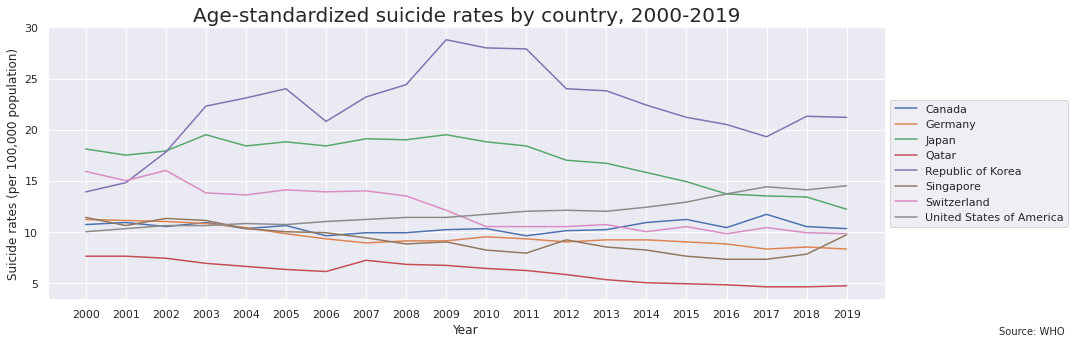

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})

x = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
     '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

for i in range(8):
  plt.plot(x, sc_sr_year_df.iloc[i, 1:].values, label = sc_sr_year_df.at[i, 'Country'])

plt.title("Age-standardized suicide rates by country, 2000-2019", size=20)
plt.xlabel("Year")
plt.ylabel("Suicide rates (per 100,000 population)")
plt.text(22.8, 0,'Source: WHO', fontsize = 10)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

I am curious about South Korea's suicide rate by age, so let's visualize it.

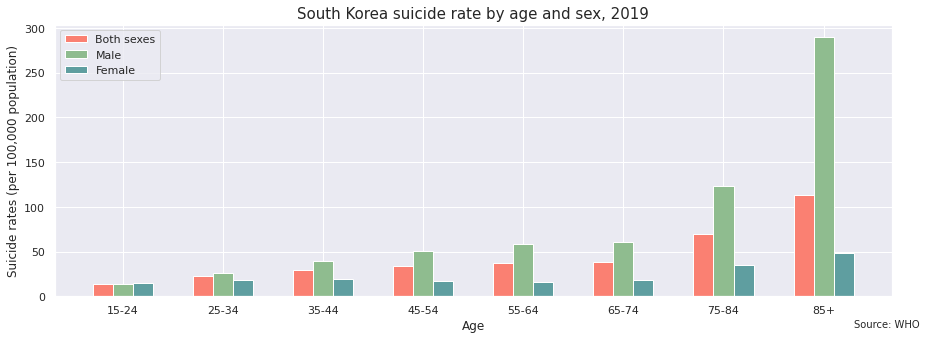

In [ ]:
N = 8
ind = np.arange(N) 
width = 0.2

both_sexes = high_income_df[high_income_df['Country']=='Republic of Korea'].iloc[0, 12:20].values
both_sexes = list(reversed(both_sexes))
bar1 = plt.bar(ind, both_sexes, width, color = 'salmon')

male = high_income_df[high_income_df['Country']=='Republic of Korea'].iloc[0, 20:28].values
male = list(reversed(male))  
bar2 = plt.bar(ind+width, male, width, color='darkseagreen')

female = high_income_df[high_income_df['Country']=='Republic of Korea'].iloc[0, 28:36].values
female = list(reversed(female))
bar3 = plt.bar(ind+width*2, female, width, color = 'cadetblue')
  
plt.xlabel("Age")
plt.ylabel('Suicide rates (per 100,000 population)')
plt.title("South Korea suicide rate by age and sex, 2019", size=15)
plt.text(7.5, -35,'Source: WHO', fontsize = 10)
plt.xticks(ind+width,['15-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '85+'])
plt.legend( (bar1, bar2, bar3), ('Both sexes', 'Male', 'Female') )
plt.show()

Let's look at some macro data.

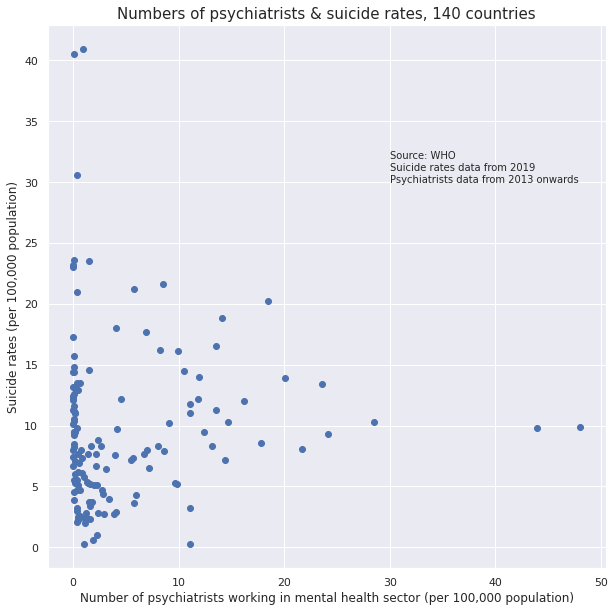

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

x = all_countries_df['Psychiatrists working in mental health sector (per 100 000 population)'].values
y = all_countries_df['sr 2019'].values
for i in range(len(y)):
  y[i] = float(y[i])

plt.title("Numbers of psychiatrists & suicide rates, 140 countries", size=15)
plt.xlabel("Number of psychiatrists working in mental health sector (per 100,000 population)")
plt.ylabel('Suicide rates (per 100,000 population)')
plt.text(30, 30,'Source: WHO\nSuicide rates data from 2019\nPsychiatrists data from 2013 onwards', fontsize = 10)

plt.scatter(x,y)
plt.show()

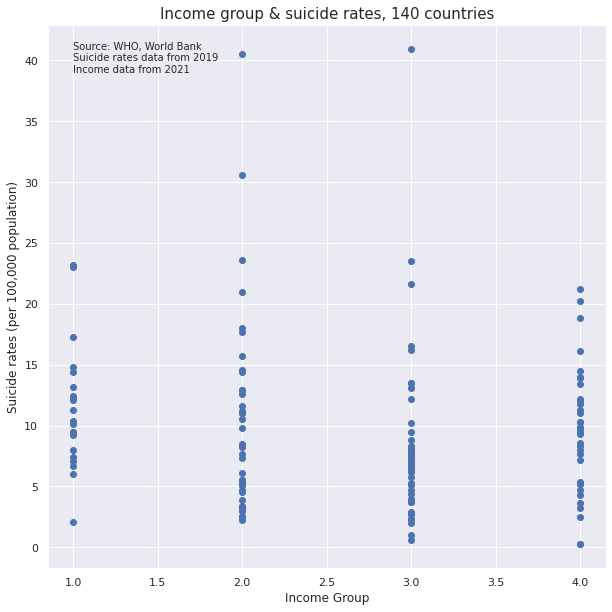

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
x = all_countries_df['Income Group'].values
y = all_countries_df['sr 2019'].values
for i in range(len(y)):
  y[i] = float(y[i])

plt.title("Income group & suicide rates, 140 countries", size=15)
plt.xlabel("Income Group")
plt.ylabel('Suicide rates (per 100,000 population)')
plt.text(1, 39,'Source: WHO, World Bank\nSuicide rates data from 2019\nIncome data from 2021', fontsize = 10)

plt.scatter(x,y)
plt.show()

There are a lot more visualization possible. But I will stop here. This is the end of the notebook.